In [25]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plt
import graphviz
import time

In [26]:
batch_size = 128
norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

def download(transforms):

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transforms)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=4, pin_memory=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transforms)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=4, pin_memory=True)

    print('Number of train samples: {}'.format(len(trainset)))
    print('Number of test samples: {}'.format(len(testset)))

    return trainloader, testloader

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [27]:
print("Class names: {}".format(classes))

Class names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [30]:
num_epochs = 5
learning_rate = 0.001
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

def train_loop(model, train_dataloader, optimizer, loss_function):
  optimizer = optimizer(model.parameters(), lr=learning_rate)
  start_all = time.time()
  for epoch in range(num_epochs):
      start = time.time()
      for images, labels in train_dataloader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = loss_function(outputs.type(torch.float32), torch.nn.functional.one_hot(labels, num_classes=10).type(torch.float32))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      end = time.time()
      print('Epoch[{}]: accuracy = {}, time = {}'.format(epoch, get_accuracy(train_dataloader, model), (end - start)))
  end_all = time.time()
  print('train time = {}'.format((end_all - start_all)))

In [31]:
def test_model(model, test_dataloader):
  model.eval()
  print('Test accuracy: {}'.format(get_accuracy(test_dataloader, model)))

# ResNet18

In [32]:
from torchvision.models import resnet18, ResNet18_Weights

resnet_18 = resnet18(ResNet18_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
for param in resnet_18.parameters():
  param.requires_grad = False
resnet_18.fc = torch.nn.Linear(resnet_18.fc.in_features, 10)
resnet_18 = resnet_18.to(device)

In [34]:
transforms = ResNet18_Weights.DEFAULT.transforms()

trainloader, testloader = download(transforms)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [35]:
resnet_18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
train_loop(resnet_18, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.7493000030517578, time = 128.34590196609497
Epoch[1]: accuracy = 0.7718200087547302, time = 131.47251963615417
Epoch[2]: accuracy = 0.7809399962425232, time = 133.3104703426361
Epoch[3]: accuracy = 0.7866999506950378, time = 125.6821756362915
Epoch[4]: accuracy = 0.7855799794197083, time = 125.06337428092957
train time = 1288.4173424243927


In [37]:
test_model(resnet_18, testloader)

Test accuracy: 0.7749999761581421


In [38]:
resnet_18_mod = resnet18(ResNet18_Weights.DEFAULT)

In [39]:
for param in resnet_18_mod.parameters():
  param.requires_grad = True
resnet_18_mod.fc = torch.nn.Linear(resnet_18_mod.fc.in_features, 10)
resnet_18_mod = resnet_18_mod.to(device)

In [40]:
resnet_18_mod

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
train_loop(resnet_18_mod, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.9049999713897705, time = 159.6229522228241
Epoch[1]: accuracy = 0.943079948425293, time = 159.0653998851776
Epoch[2]: accuracy = 0.9535799622535706, time = 159.4908573627472
Epoch[3]: accuracy = 0.9715399742126465, time = 158.97770714759827
Epoch[4]: accuracy = 0.9732399582862854, time = 158.75169825553894
train time = 1427.307449579239


In [42]:
test_model(resnet_18_mod, testloader)

Test accuracy: 0.9068999886512756


# ResNet50


In [43]:
from torchvision.models import resnet50, ResNet50_Weights

resnet_50 = resnet50(ResNet50_Weights.DEFAULT)

In [44]:
for param in resnet_50.parameters():
  param.requires_grad = False
resnet_50.fc = torch.nn.Linear(resnet_50.fc.in_features, 10)
resnet_50 = resnet_50.to(device)

In [45]:
transforms = ResNet50_Weights.DEFAULT.transforms()

trainloader, testloader = download(transforms)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [46]:
resnet_50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
train_loop(resnet_50, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.7793799638748169, time = 166.02904438972473
Epoch[1]: accuracy = 0.807699978351593, time = 165.84190344810486
Epoch[2]: accuracy = 0.8173999786376953, time = 165.73097229003906
Epoch[3]: accuracy = 0.8296999931335449, time = 166.14438676834106
Epoch[4]: accuracy = 0.8345399498939514, time = 165.08692455291748
train time = 1660.9940690994263


In [48]:
test_model(resnet_50, testloader)

Test accuracy: 0.8087999820709229


In [49]:
resnet_50_mod = resnet50(ResNet50_Weights.DEFAULT)

In [50]:
for param in resnet_50_mod.parameters():
  param.requires_grad = True
resnet_50_mod.fc = torch.nn.Linear(resnet_50_mod.fc.in_features, 10)
resnet_50_mod = resnet_50_mod.to(device)

In [51]:
resnet_50_mod

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
train_loop(resnet_50_mod, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.9321999549865723, time = 514.6681118011475
Epoch[1]: accuracy = 0.9546200037002563, time = 514.7898983955383
Epoch[2]: accuracy = 0.9696599841117859, time = 514.9564063549042
Epoch[3]: accuracy = 0.9660599827766418, time = 515.9533212184906
Epoch[4]: accuracy = 0.9767599701881409, time = 514.830073595047
train time = 3406.4262862205505


In [53]:
test_model(resnet_50_mod, testloader)

Test accuracy: 0.9268999695777893


# SHUFFLENET_V2_X0_5

In [54]:
from torchvision.models import ShuffleNet_V2_X0_5_Weights

shuffleNet_v2_x0_5 = torchvision.models.quantization.shufflenet_v2_x0_5(ShuffleNet_V2_X0_5_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 33.1MB/s]


In [55]:
for param in shuffleNet_v2_x0_5.parameters():
  param.requires_grad = False
shuffleNet_v2_x0_5.fc = torch.nn.Linear(shuffleNet_v2_x0_5.fc.in_features, 10)
shuffleNet_v2_x0_5 = shuffleNet_v2_x0_5.to(device)

In [56]:
transforms = ShuffleNet_V2_X0_5_Weights.DEFAULT.transforms()

trainloader, testloader = download(transforms)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [57]:
shuffleNet_v2_x0_5

QuantizableShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): QuantizableInvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [58]:
train_loop(shuffleNet_v2_x0_5, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.686739981174469, time = 122.58343863487244
Epoch[1]: accuracy = 0.7041800022125244, time = 125.0372748374939
Epoch[2]: accuracy = 0.7186399698257446, time = 122.78673768043518
Epoch[3]: accuracy = 0.7311599850654602, time = 123.59352731704712
Epoch[4]: accuracy = 0.738379955291748, time = 125.41995334625244
train time = 1235.8749780654907


In [59]:
test_model(shuffleNet_v2_x0_5, testloader)

Test accuracy: 0.7336999773979187


In [60]:
shuffleNet_v2_x0_5_mod = torchvision.models.quantization.shufflenet_v2_x0_5(ShuffleNet_V2_X0_5_Weights.DEFAULT)

In [61]:
for param in shuffleNet_v2_x0_5_mod.parameters():
  param.requires_grad = True
shuffleNet_v2_x0_5_mod.fc = torch.nn.Linear(shuffleNet_v2_x0_5_mod.fc.in_features, 10)
shuffleNet_v2_x0_5_mod = shuffleNet_v2_x0_5_mod.to(device)

In [62]:
shuffleNet_v2_x0_5_mod

QuantizableShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): QuantizableInvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [63]:
train_loop(shuffleNet_v2_x0_5_mod, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.8792999982833862, time = 130.38961267471313
Epoch[1]: accuracy = 0.9080999493598938, time = 130.46158599853516
Epoch[2]: accuracy = 0.9292199611663818, time = 129.8230173587799
Epoch[3]: accuracy = 0.9422199726104736, time = 130.69646525382996
Epoch[4]: accuracy = 0.9464199542999268, time = 129.54870581626892
train time = 1268.239429950714


In [64]:
test_model(shuffleNet_v2_x0_5_mod, testloader)

Test accuracy: 0.8898999691009521


# GoogLeNet

In [65]:
from torchvision.models import googlenet, GoogLeNet_Weights

googLeNet = googlenet(GoogLeNet_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 76.0MB/s]


In [66]:
for param in googLeNet.parameters():
  param.requires_grad = False
googLeNet.fc = torch.nn.Linear(googLeNet.fc.in_features, 10)
googLeNet = googLeNet.to(device)

In [67]:
transforms = GoogLeNet_Weights.DEFAULT.transforms()

trainloader, testloader = download(transforms)

Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


In [68]:
googLeNet

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [69]:
train_loop(googLeNet, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.7391999959945679, time = 127.03830766677856
Epoch[1]: accuracy = 0.7565799951553345, time = 126.74658274650574
Epoch[2]: accuracy = 0.7639399766921997, time = 127.09241724014282
Epoch[3]: accuracy = 0.7663599848747253, time = 126.58890795707703
Epoch[4]: accuracy = 0.7699999809265137, time = 128.2115294933319
train time = 1279.0839338302612


In [70]:
test_model(googLeNet, testloader)

Test accuracy: 0.7777999639511108


In [71]:
googLeNet_mod = googlenet(GoogLeNet_Weights.DEFAULT)

In [72]:
for param in googLeNet_mod.parameters():
  param.requires_grad = True
googLeNet_mod.fc = torch.nn.Linear(googLeNet_mod.fc.in_features, 10)
googLeNet_mod = googLeNet_mod.to(device)

In [73]:
googLeNet_mod

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [74]:
train_loop(googLeNet_mod, trainloader, optimizer, loss_function)

Epoch[0]: accuracy = 0.9163199663162231, time = 189.83211994171143
Epoch[1]: accuracy = 0.9465199708938599, time = 190.0375053882599
Epoch[2]: accuracy = 0.9516399502754211, time = 190.83022618293762
Epoch[3]: accuracy = 0.969819962978363, time = 191.06820940971375
Epoch[4]: accuracy = 0.9726600050926208, time = 190.5698618888855
train time = 1594.9757134914398


In [75]:
test_model(googLeNet_mod, testloader)

Test accuracy: 0.9208999872207642


# Results

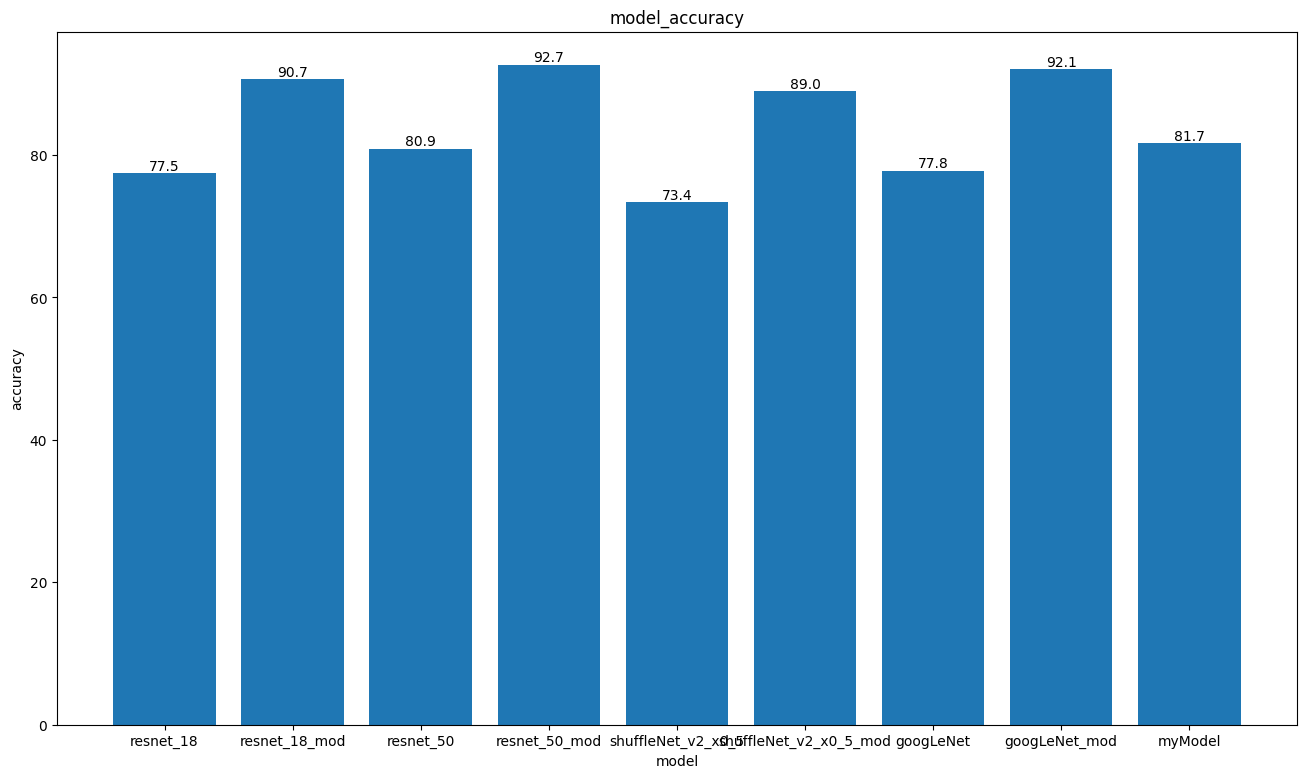

In [85]:
model_names = ['resnet_18', 'resnet_18_mod',  'resnet_50', 'resnet_50_mod',
               'shuffleNet_v2_x0_5', 'shuffleNet_v2_x0_5_mod', 'googLeNet', 'googLeNet_mod', 'myModel']
accuracies = [0.7749, 0.9069, 0.8088, 0.9269, 0.7337, 0.8899, 0.7778, 0.9209, 0.8173]
accuracies = list(map(lambda x: round(x*100,1), accuracies))

plt.figure(figsize=(16, 9))
plt.bar(model_names, accuracies)
for i in range(len(accuracies)):
  plt.text(i, accuracies[i], f"{accuracies[i]:.1f}", ha='center', va='bottom')

plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('model_accuracy')

plt.show()